**Table of contents**<a id='toc0_'></a>    
- 1. [Measure synchronization of tremor in Alaska](#toc1_)    
- 2. [Load data](#toc2_)    
- 3. [Measure correlation distance](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Measure synchronization of tremor in Alaska [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from stats import cross_corr

In [2]:
mag_min = 2.2


# 2. <a id='toc2_'></a>Load data [&#128285;](#toc0_)

In [3]:
day0 = np.datetime64('2013-01-01')

In [4]:
# Tremor data
trm = pd.read_csv('data/alaska/processed/ak_trm_0113_1015_zslab2_eqdist_mc{:.1f}.csv'.format(mag_min), parse_dates=['date'])
trm['day'] = (trm.date - day0) / np.timedelta64(1, 'D')

In [5]:
# Earthquake data
eq = pd.read_csv('data/alaska/processed/ak_eqmc{:.1f}_0113_1015_eqdist.csv'.format(mag_min))

strip = lambda x: str.removesuffix(x, '+00:00')
eq['date'] = list(map(strip, eq.date))
eq['date'] = pd.to_datetime(eq.date, format='mixed')

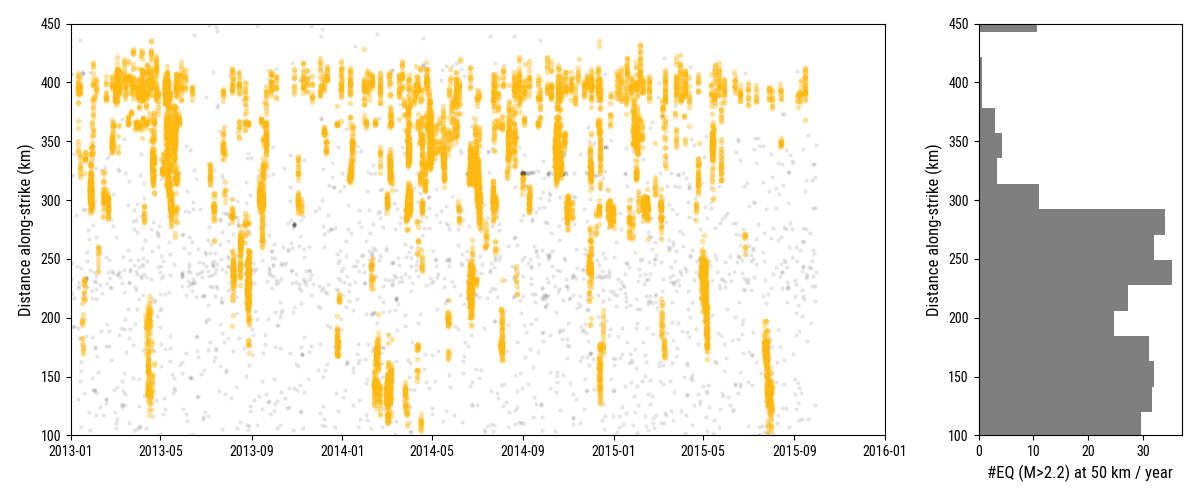

In [6]:
# Overview
dist = 50

fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1])

# Activity in time and space
ax = fig.add_subplot(gs[0])
ax.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2016-01-01'))
ax.set_ylim(100, 450)
ax.set_ylabel('Distance along-strike (km)')
ax.plot(trm.date, trm.xf, 'o', c=to_rgba('C2', .4), mec=[0,0,0,0], ms=4)
ax.plot(eq.date, eq.xf, 'o', c=to_rgba('k', .1), mec=[0,0,0,0], ms=3, zorder=0)

# Number of earthquakes
ax = fig.add_subplot(gs[1], sharey=ax)
ax.set_xlabel('#EQ (M>{:.1f}) at {:d} km / year'.format(mag_min, dist))
ax.set_ylabel('Distance along-strike (km)')
ax.hist(eq.xf[eq['in{:d}km'.format(dist)]], weights=np.ones(len(eq.xf[eq['in{:d}km'.format(dist)]]))/3, bins=20, orientation='horizontal', color='k', alpha=.5)

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Measure correlation distance [&#128285;](#toc0_)

In [7]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 100
xmax_bin = 450
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

In [8]:
# Make the matrix of cross-correlation — Computation (takes time, 30s for bins of 10 km, 1 day, 1000 km wide)
# --> Make the counts
count_time = np.arange(0, trm.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    trm_in_bin = trm.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(trm[trm_in_bin].day.values, bins=count_time)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            if ~np.any(counts[ii, :]) or ~np.any(counts[jj, :]):
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.nan
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = np.nan
            else:
                cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
                
                if look_both_ways:
                    cc = (cc + cc[::-1]) / 2
                    cc = cc[lag >= 0]
                    lag = lag[lag >= 0]
                
                in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii])/2 - (x_bin_edges[jj+1] + x_bin_edges[jj])/2) / v_min
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]

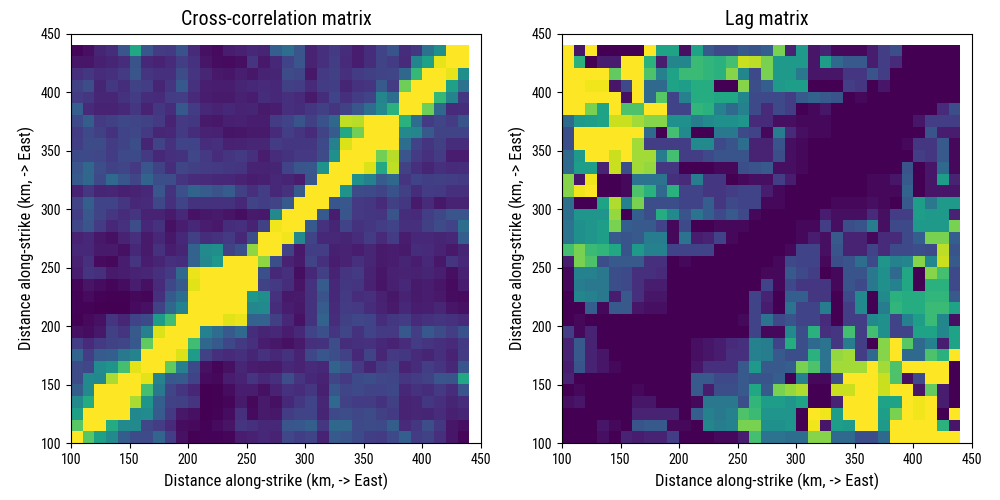

In [9]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]

cax = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmax=.5, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> East)')
ax.set_ylabel('Distance along-strike (km, -> East)')
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmin=0, vmax=50, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> East)')
ax.set_ylabel('Distance along-strike (km, -> East)')
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

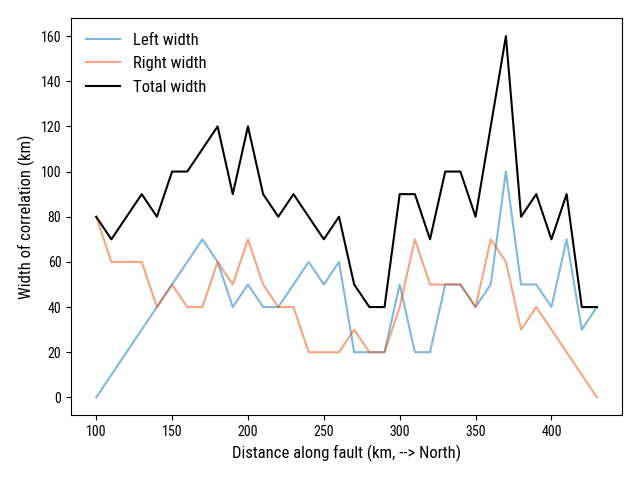

In [10]:
# Instead of fitting, just look how far you are above a threshold
threshold_cc = .07
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    # Look right
    jj = ii
    while (jj < len(x_bin_edges)-1) and (cc_matrix[ii, jj] > threshold_cc):
        jj += 1
    right_width.append(x_bin_edges[jj-1] - x_bin_edges[ii])

    # Look left
    jj = ii
    while (jj >= 0) and (cc_matrix[ii, jj] > threshold_cc):
        jj -= 1
    left_width.append(x_bin_edges[ii] - x_bin_edges[jj+1])

left_width = np.array(left_width).astype(float)
right_width = np.array(right_width).astype(float)

# Remove wrong points
left_width[~np.any(counts, axis=1)] = np.nan
right_width[~np.any(counts, axis=1)] = np.nan

corr_length = np.array(left_width) + np.array(right_width)

# Show results
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, '-', label='Left width', alpha=0.5)
ax.plot(x_bin_edges[:-1], right_width, '-', label='Right width', alpha=0.5)
ax.plot(x_bin_edges[:-1], corr_length, 'k-', label='Total width', ms=8)
ax.legend()
plt.tight_layout()
plt.show()

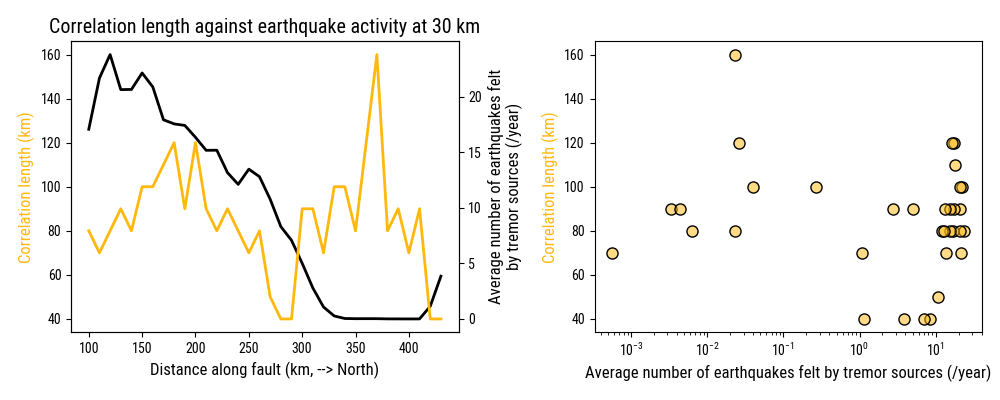

In [11]:
# Against earthquake activity
# --> Compute binned measure of earthquake activity
dists = [10, 20, 30, 50, 100]  # different distances in km

n_close_eq = {}
for dist in dists:
    n_close_eq[dist] = np.zeros(len(x_bin_edges)-1)
    for ii in range(len(x_bin_edges)-1):
        x_min = x_bin_edges[ii]
        x_max = x_bin_edges[ii+1]
        trm_in_bin = trm[trm.xf.between(x_min, x_max)]
        n_close_eq[dist][ii] = np.mean(trm_in_bin[f'n_eq_{dist}km'])

# Plot
chosen_dist = 30
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --> In space
ax = axes[0]
ax.set_title(f'Correlation length against earthquake activity at {chosen_dist} km')
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(x_bin_edges[:-1], corr_length, 'C2-', lw=2)

ax_eq = ax.twinx()
ax_eq.set_zorder(-10)
ax.set_facecolor('none')
ax_eq.set_ylabel('Average number of earthquakes felt\nby tremor sources (/year)', color='k')
ax_eq.plot(x_bin_edges[:-1], n_close_eq[chosen_dist], 'k-', lw=2)

# --> One against the other
ax = axes[1]
ax.set_xlabel('Average number of earthquakes felt by tremor sources (/year)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(n_close_eq[chosen_dist], corr_length, 'o', ms=8, mec='k', mfc=to_rgba('C2', .5))
ax.set_xscale('log')

plt.tight_layout()
plt.show()

In [12]:
# Stats
from scipy.stats import linregress

# Remove nans for the regression
n_eq = n_close_eq[chosen_dist][~np.isnan(corr_length)]
corr_l = corr_length[~np.isnan(corr_length)]

slope, intercept, r_value, p_value, std_err = linregress(n_eq, corr_l)
print('Slope:{:.2f}'.format(slope))
print('Error on slope (std): ±{:.2f}'.format(std_err))
print('Corellation coefficient:{:.2f}'.format(r_value))

SSres = np.sum((corr_l - (slope * n_eq + intercept))**2)  # sum of squares of residuals
SStot = np.sum((corr_l - np.mean(corr_l))**2)  # total sum of squares
R2 = 1 - SSres / SStot
print('Percentage of variance explained (R²): {:.1f}%'.format(100*R2))

Slope:0.18
Error on slope (std): ±0.53
Corellation coefficient:0.06
Percentage of variance explained (R²): 0.3%


In [13]:
# Save results
import pickle
results = {'corr_length': corr_length, 'n_close_eq': n_close_eq, 'dists':dists, 'cc_thr':threshold_cc, 'dx':dx_bin, 'dt': delta}

path = 'results/ak_synch_mc{:.1f}_dx{:d}_cc{:.2f}.pkl'.format(mag_min, int(dx_bin), threshold_cc)
with open(path, 'wb') as f:
    print('Saving results to', path)
    pickle.dump(results, f)

Saving results to results/ak_synch_mc2.2_dx10_cc0.07.pkl


# Figures for the paper

In [14]:
chosen_dist = 50

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_51395/309640315.py:103: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], s=5, c=to_rgba('C2', .5), label='Tremor')
/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_51395/309640315.py:104: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], s=5, c=to_rgba('k', .5), label='Earthquakes')


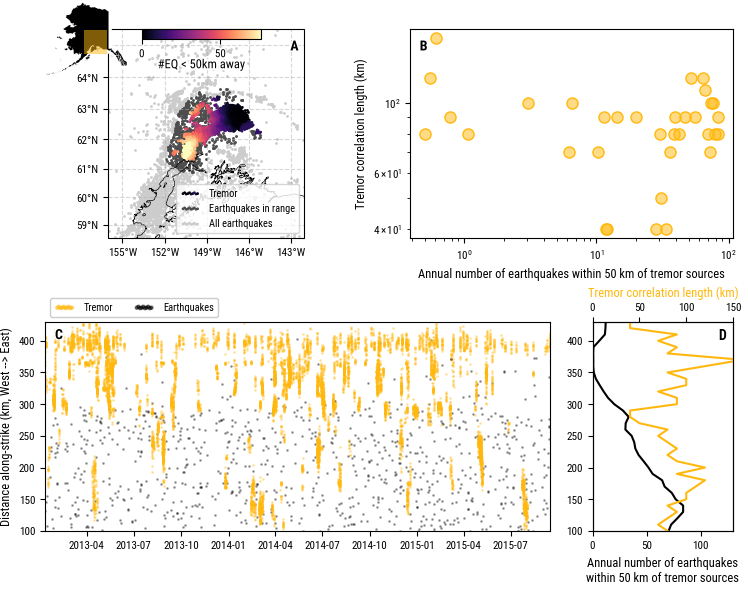

In [16]:
# Plot
import matplotlib.patheffects as fx

with plt.style.context('grl'):
    fig = plt.figure(figsize=np.array([19, 15])/2.54)
    gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1])

    plt.subplots_adjust(left=0.06, right=0.98, top=.95, bottom=0.1, wspace=0.3, hspace=0.4)

    # Map
    crs = ccrs.Mercator(central_longitude=trm.lon.mean())
    lon_min = eq.lon.min()
    lon_max = eq.lon.max()
    lat_min = eq.lat.min()
    lat_max = eq.lat.max()

    ax = fig.add_subplot(gs[0, :2], projection=crs)
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    ax.coastlines(lw=.5)

    sc = ax.scatter(trm.lon, trm.lat, c=trm.n_eq_50km, s=1, cmap='magma', transform=ccrs.PlateCarree(), vmin=0, vmax=np.percentile(trm.n_eq_50km, 95), zorder=2, label='Tremor', rasterized=True)
    ax.scatter(eq.lon[eq.in50km], eq.lat[eq.in50km], c='.3', s=1, transform=ccrs.PlateCarree(), zorder=1, label='Earthquakes in range', rasterized=True)
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=ccrs.PlateCarree(), zorder=0, label='All earthquakes', rasterized=True)

    ax.legend(loc='lower right', bbox_to_anchor=(1, 0), fontsize='small', framealpha=.8, scatterpoints=10, markerscale=1)

    # Colorbar
    x_min_ax = 0.3; y_min_ax = 0.95
    w_ax = 0.37; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    x_min_fig, y_min_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_min_ax, y_min_ax]))
    x_max_fig, y_max_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_max_ax, y_max_ax]))
    h_fig = y_max_fig - y_min_fig
    w_fig = x_max_fig - x_min_fig

    cb_ax= fig.add_axes([x_min_fig, y_min_fig, w_fig, h_fig])
    cbar = plt.colorbar(sc, cax=cb_ax, orientation='horizontal', label="#EQ < {:d}km away".format(chosen_dist))

    for label in cb_ax.get_xticklabels():
        label.set(path_effects=[fx.withStroke(linewidth=2, foreground='w')])
    cb_ax.xaxis.get_label().set(path_effects=[fx.withStroke(linewidth=3, foreground='w')])
    cb_ax.xaxis.get_label().set_va('center')

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 3), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

    ax.text(0.97, 0.95, 'A', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='right', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Inset
    # get Alaska country shape
    import shapely.geometry as sgeom
    import cartopy.io.shapereader as shpreader

    shpfilename = shpreader.natural_earth(resolution='50m',
                                        category='cultural',
                                        name='admin_1_states_provinces_lakes')
    reader = shpreader.Reader(shpfilename)
    countries = reader.records()

    alaska = None
    for country in countries:
        if country.attributes['name'] == 'Alaska':
            alaska = country.geometry

    ax = plt.axes([.05, .87, .13, .13], projection=ccrs.Mercator())
    ax.axis('off')
    ax.set_extent([-179, -130, 51, 72], crs=ccrs.PlateCarree())
    ax.add_geometries([alaska], ccrs.PlateCarree(), facecolor='k', edgecolor='w', lw=4, zorder=0)    
    ax.add_geometries([alaska], ccrs.PlateCarree(), facecolor='k', edgecolor='none', lw=1, zorder=2)

    # show patch of main map
    rect = plt.Rectangle((lon_min, lat_min), lon_max-lon_min, lat_max-lat_min, transform=ccrs.PlateCarree(), edgecolor='none', facecolor=to_rgba('C2', .5), zorder=3)
    ax.add_patch(rect)

    # Dot cloud
    ax = fig.add_subplot(gs[0, 2:])
    ax.set_xlabel('Annual number of earthquakes within 50 km of tremor sources')
    ax.set_ylabel('Tremor correlation length (km)')

    ax.plot(n_close_eq[chosen_dist], corr_length, 'o', ms=8, mec='C2', mfc=to_rgba('C2', .5))

    # ax.set_xlim(9, 200)
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.text(0.03, 0.95, 'B', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Time-strike activity
    ax = fig.add_subplot(gs[1, :3])
    ax.set_ylabel('Distance along-strike (km, West --> East)')

    ax.plot(trm.date, trm.xf, 'o', ms=1, color=to_rgba('C2', .3), rasterized=True)
    ax.plot(eq.date[eq.in50km], eq.xf[eq.in50km], 'o', ms=1., color=to_rgba('k', .3), zorder=0, rasterized=True)

    ax.set_xlim(trm.date.min(), trm.date.max())
    ax.set_ylim(100, 430)

    ax.scatter([], [], s=5, c=to_rgba('C2', .5), label='Tremor')
    ax.scatter([], [], s=5, c=to_rgba('k', .5), label='Earthquakes')
    ax.legend(loc='lower left', bbox_to_anchor=(0, 1.), framealpha=1, fontsize='small', scatterpoints=10, markerscale=1, ncols=2)

    ax.text(0.02, 0.97, 'C', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='left', va='top', path_effects=[fx.withStroke(linewidth=2, foreground='w')])

    # Histogram
    ax = fig.add_subplot(gs[1, 3], sharey=ax)
    ax.set_xlabel('Annual number of earthquakes\nwithin 50 km of tremor sources')
    ax.set_xlim(0, 130)

    ax.plot(n_close_eq[chosen_dist], x_bin_edges[:-1], c='k')

    ax_cc = ax.twiny()
    ax_cc.set_xlim(0, 150)
    ax_cc.plot(corr_length, x_bin_edges[:-1], 'C2')
    ax_cc.set_xlabel('Tremor correlation length (km)', color='C2')

    ax.text(0.95, 0.97, 'D', fontsize=10, fontweight='bold', transform=ax.transAxes, ha='right', va='top')
    
    plt.savefig('figures/alaska_supp.png', dpi=300)
    plt.savefig('figures/alaska_supp.pdf', dpi=300)
    plt.show()